# Survival Analysis test
Aim 2ish: What factors are predictive of length of treatment?

In [23]:
#load libraries
library(survival)
install.packages("ranger", repos='http://cran.us.r-project.org') 
library(ranger)
library(dplyr)
library(ggplot2)
install.packages("ggfortify", repos='http://cran.us.r-project.org')
library(ggfortify)


Warning message:
"package 'ranger' is in use and will not be installed"also installing the dependency 'gridExtra'



package 'gridExtra' successfully unpacked and MD5 sums checked
package 'ggfortify' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\MB047320\AppData\Local\Temp\RtmpYrmoLM\downloaded_packages


The dataset of interest is the 'veteran' data from survival package. It represents some form of RCT for lung cancer treatments.

In [26]:
data(veteran)
head(veteran)

trt,celltype,time,status,karno,diagtime,age,prior
1,squamous,72,1,60,7,69,0
1,squamous,411,1,70,5,64,10
1,squamous,228,1,60,3,38,0
1,squamous,126,1,60,9,63,10
1,squamous,118,1,70,11,65,10
1,squamous,10,1,20,5,49,0


# Variables:
trt = 1 (standard), 2 (test) <br>
celltype = type of lung cancer cell  <br>
time = survival time in days <br>
status = censoring status (1 indicates observed death) <br>
karno = performance score (100 = good) <br>
diagtime = months from diagnosis to randomization <br>
age = yrs <br>
prior = prior therapy; 0 = no, 10 = yes



## Kaplan Meier Analysis

In [28]:
#surv() to build survival object
km <- with(veteran, Surv(time, status))

In [29]:
head(km, 20)

 [1]  72  411  228  126  118   10   82  110  314  100+  42    8  144   25+  11 
[16]  30  384    4   54   13 

Note that any '+' observed in dataframe indicates right censoring, or the absence of the event of interest during the study period. <br>
<br>
Next, produce Kaplan Meier estimates of the probability of survival over time.

In [31]:
km_fit <- survfit(Surv(time,status)~1, data = veteran)
summary(km_fit, times = c(1,30,60,90*(1:10))) #prints estimates for 1,30,etc, days, then every 90 days after

Call: survfit(formula = Surv(time, status) ~ 1, data = veteran)

 time n.risk n.event survival std.err lower 95% CI upper 95% CI
    1    137       2    0.985  0.0102      0.96552       1.0000
   30     97      39    0.700  0.0392      0.62774       0.7816
   60     73      22    0.538  0.0427      0.46070       0.6288
   90     62      10    0.464  0.0428      0.38731       0.5560
  180     27      30    0.222  0.0369      0.16066       0.3079
  270     16       9    0.144  0.0319      0.09338       0.2223
  360     10       6    0.090  0.0265      0.05061       0.1602
  450      5       5    0.045  0.0194      0.01931       0.1049
  540      4       1    0.036  0.0175      0.01389       0.0934
  630      2       2    0.018  0.0126      0.00459       0.0707
  720      2       0    0.018  0.0126      0.00459       0.0707
  810      2       0    0.018  0.0126      0.00459       0.0707
  900      2       0    0.018  0.0126      0.00459       0.0707

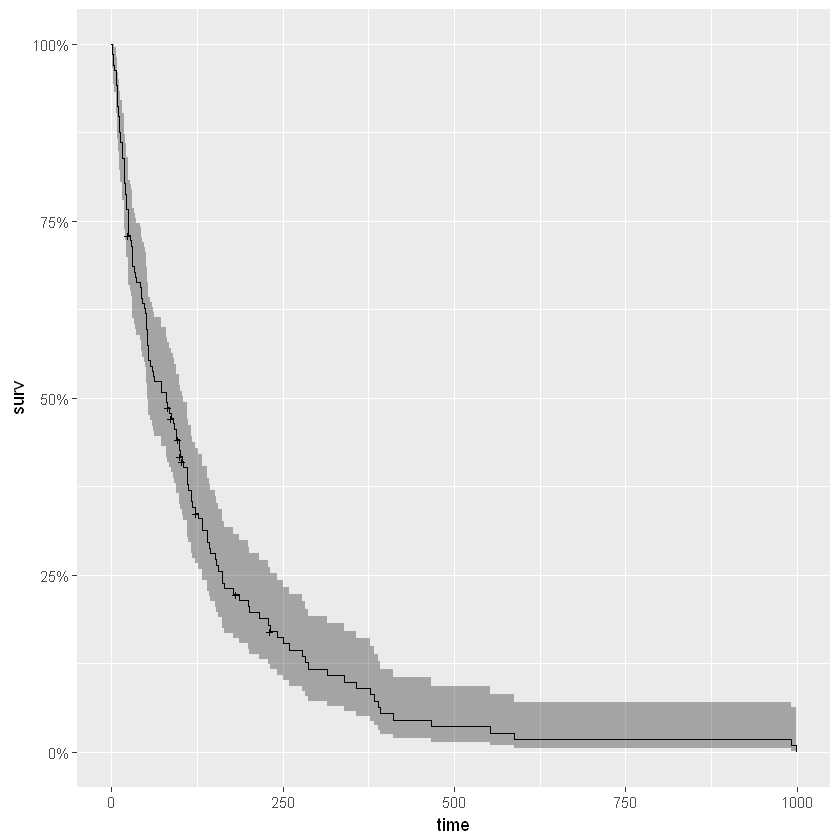

In [32]:
#plot general survival curve
autoplot(km_fit)

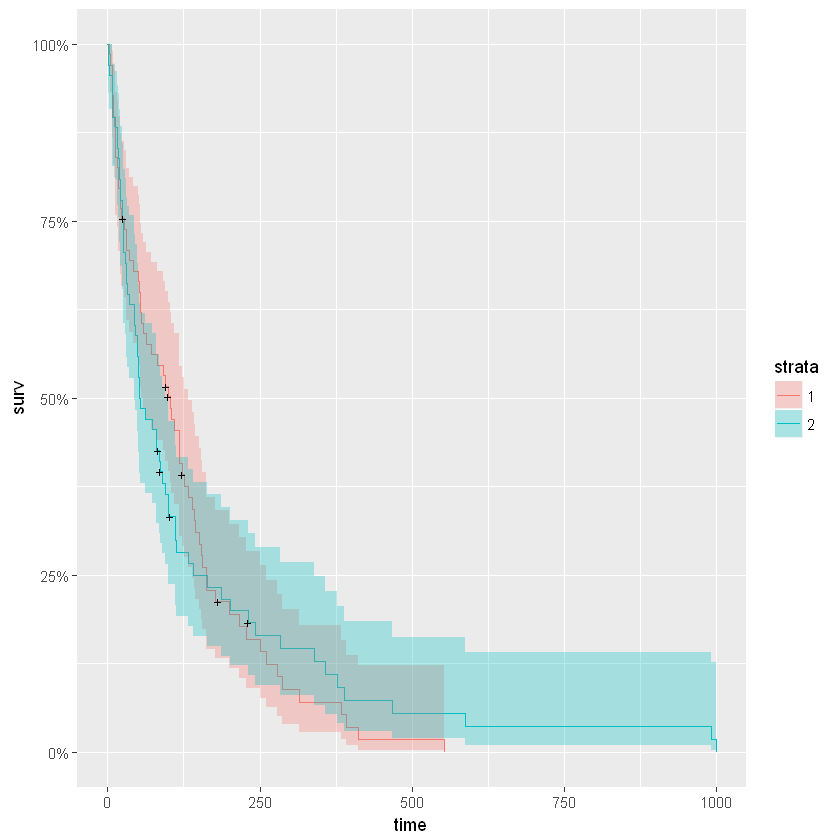

In [34]:
#plot survival curve by treatment (aka strata)
km_trt_fit <- survfit(Surv(time,status)~ trt, data = veteran) #need to refit with trt as a grouper
autoplot(km_trt_fit)

For exploratory purposes, looking at survival by age could be worthwhile. Since the dataset is made up of older veterans, 60 years of age was used to dichotomize the dataset.

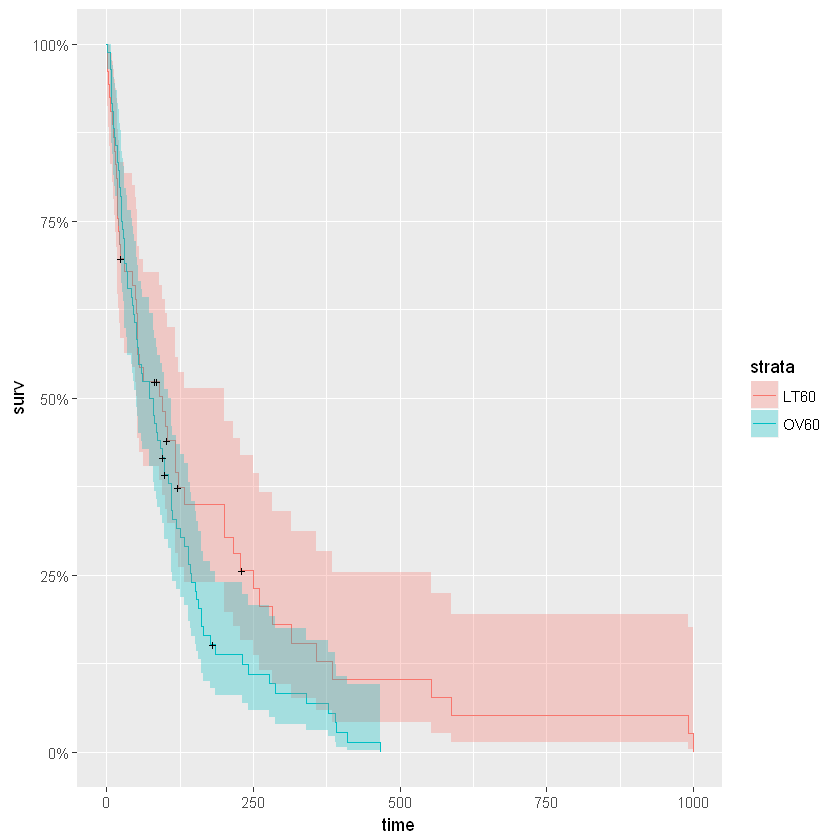

In [41]:
#create new dataframe with age separated into dummy (60yo)
vet <- mutate(veteran, AG = ifelse((age < 60), "LT60", "OV60"),
             AG = factor(AG),
             trt = factor(trt, labels = c("standard", "test")),
             prior = factor(prior, labels = c("NO", "YES")))
km_AG_fit <- survfit(Surv(time,status) ~ AG, data = vet)
autoplot(km_AG_fit)

Although the 2 curves appear to overlap a bit in the first 50 days, younger patients clearly have a better chance of surviving more than a year.

<br>
<br>

# Cox Proportional Hazards Model

https://en.wikipedia.org/wiki/Proportional_hazards_model <br>
makes use of all the covariates in the data set.

In [43]:
cox <- coxph(Surv(time, status) ~ trt + celltype + karno + diagtime + age + prior , data = vet)
summary(cox)

Call:
coxph(formula = Surv(time, status) ~ trt + celltype + karno + 
    diagtime + age + prior, data = vet)

  n= 137, number of events= 128 

                        coef  exp(coef)   se(coef)      z Pr(>|z|)    
trttest            2.946e-01  1.343e+00  2.075e-01  1.419  0.15577    
celltypesmallcell  8.616e-01  2.367e+00  2.753e-01  3.130  0.00175 ** 
celltypeadeno      1.196e+00  3.307e+00  3.009e-01  3.975 7.05e-05 ***
celltypelarge      4.013e-01  1.494e+00  2.827e-01  1.420  0.15574    
karno             -3.282e-02  9.677e-01  5.508e-03 -5.958 2.55e-09 ***
diagtime           8.132e-05  1.000e+00  9.136e-03  0.009  0.99290    
age               -8.706e-03  9.913e-01  9.300e-03 -0.936  0.34920    
priorYES           7.159e-02  1.074e+00  2.323e-01  0.308  0.75794    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

                  exp(coef) exp(-coef) lower .95 upper .95
trttest              1.3426     0.7448    0.8939    2.0166
celltypesmallcell    2.3669    

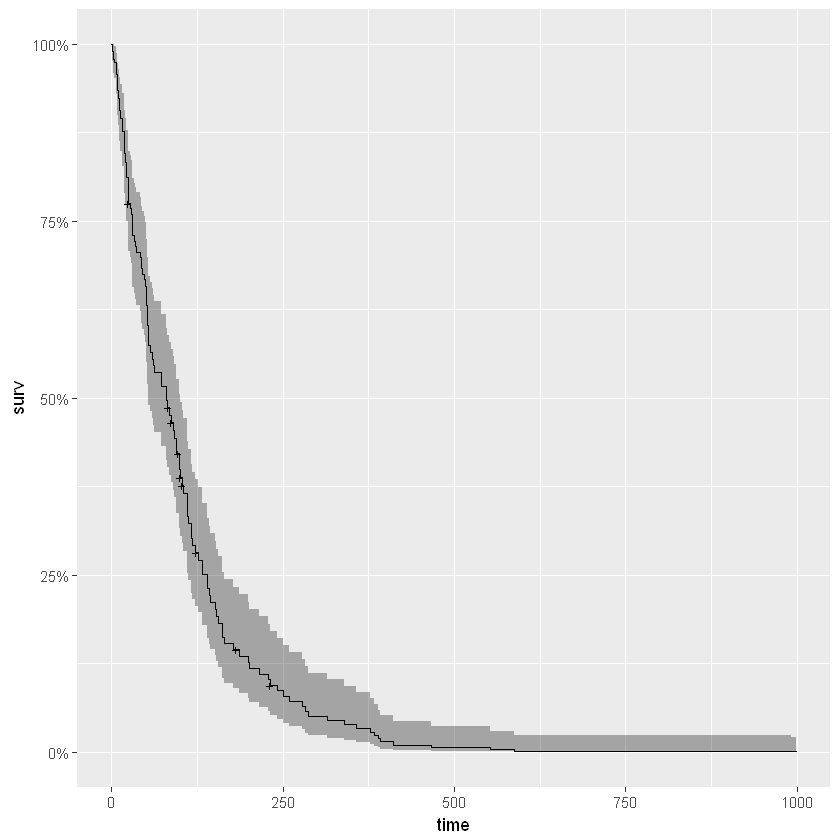

In [45]:
cox_fit <- survfit(cox)
autoplot(cox_fit)

model flags small cell type, adeno cell type, and karno as significant covariates. But interpretation needs to assume covariates don't vary with time. Karno is time dependent, so the assumption for Cox model are not met. (there are strategies for dealing with this here:) <br>
https://cran.r-project.org/web/packages/survival/vignettes/timedep.pdf

ROC-like statistic could be calculated, called Concordance statistic, and represents probability of agreement for any two randomly chosen observations, where in this case agreement means that the observation with the shorter survival time of the two also has the larger risk score. The predictor (or risk score) will often be the result of a cox model or other regression. For continuous covariates, concordance is equivalent to Kendall's Tau, and for logistic regress it is equivalent to AUC ROC.

<br>
<br>
# Random Forests Model

Use ranger() function to fit a Random Forest ensemble model to the data. Ranger builds a model for each observation in the dataset. The next block of code builds the model using the same variables used in the Cox model above and plots 20 random curves, along with a curve that represetns the global average for all patients.

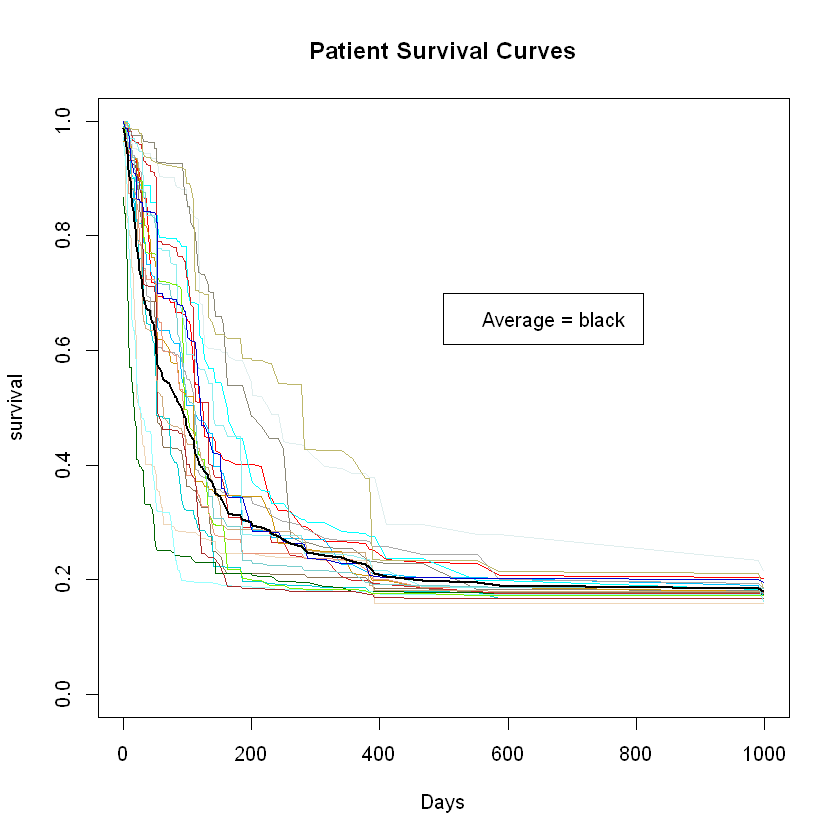

In [46]:
# ranger model
r_fit <- ranger(Surv(time, status) ~ trt + celltype + 
                     karno + diagtime + age + prior,
                     data = vet,
                     mtry = 4,
                     importance = "permutation",
                     splitrule = "extratrees",
                     verbose = TRUE)

# Average the survival models
death_times <- r_fit$unique.death.times 
surv_prob <- data.frame(r_fit$survival)
avg_prob <- sapply(surv_prob,mean)

# Plot the survival models for each patient
plot(r_fit$unique.death.times,r_fit$survival[1,], 
     type = "l", 
     ylim = c(0,1),
     col = "red",
     xlab = "Days",
     ylab = "survival",
     main = "Patient Survival Curves")

#
cols <- colors()
for (n in sample(c(2:dim(vet)[1]), 20)){
  lines(r_fit$unique.death.times, r_fit$survival[n,], type = "l", col = cols[n])
}
lines(death_times, avg_prob, lwd = 2)
legend(500, 0.7, legend = c('Average = black'))

In [48]:
#Ranger rank of variable importance
vi <- data.frame(sort(round(r_fit$variable.importance, 4), decreasing = TRUE))
names(vi) <- "importance"
head(vi)


,importance
karno,0.0919
celltype,0.0340
diagtime,0.0036
prior,0.0012
trt,-0.0011
age,-0.0037


Ranger flagged karno and celltype as the two most important variables, the same variables with the lowest p-values in the Cox model. (notice that there are no level names, as tree-based models don't dummify factors)<br>
<br>
Ranger does compute Harrell's c-index, again similar to the Concordance statistic. Generalizes as the ROC, which is reduced to the Wilcoxon-Mann-Whitney stat for binary variables (again, similar to AUC ROC)

In [50]:
cat("Prediction Error = 1 - Harrell's c-index = ", r_fit$prediction.error)

Prediction Error = 1 - Harrell's c-index =  0.2997501

An ROC > .60 would be pretty good for the first try (i.e. Harrell's index in this case is 1 - .299 = .701). But it should be noted that time-varying data elements (karno...) aren't converted or controlled. But helpful to plot for interpretation.

In [53]:
# Set up for ggplot
kmi <- rep("KM",length(km_fit$time))
km_df <- data.frame(km_fit$time,km_fit$surv,kmi)
names(km_df) <- c("Time","Surv","Model")

coxi <- rep("Cox",length(cox_fit$time))
cox_df <- data.frame(cox_fit$time,cox_fit$surv,coxi)
names(cox_df) <- c("Time","Surv","Model")

rfi <- rep("RF",length(r_fit$unique.death.times))
rf_df <- data.frame(r_fit$unique.death.times,avg_prob,rfi)
names(rf_df) <- c("Time","Surv","Model")

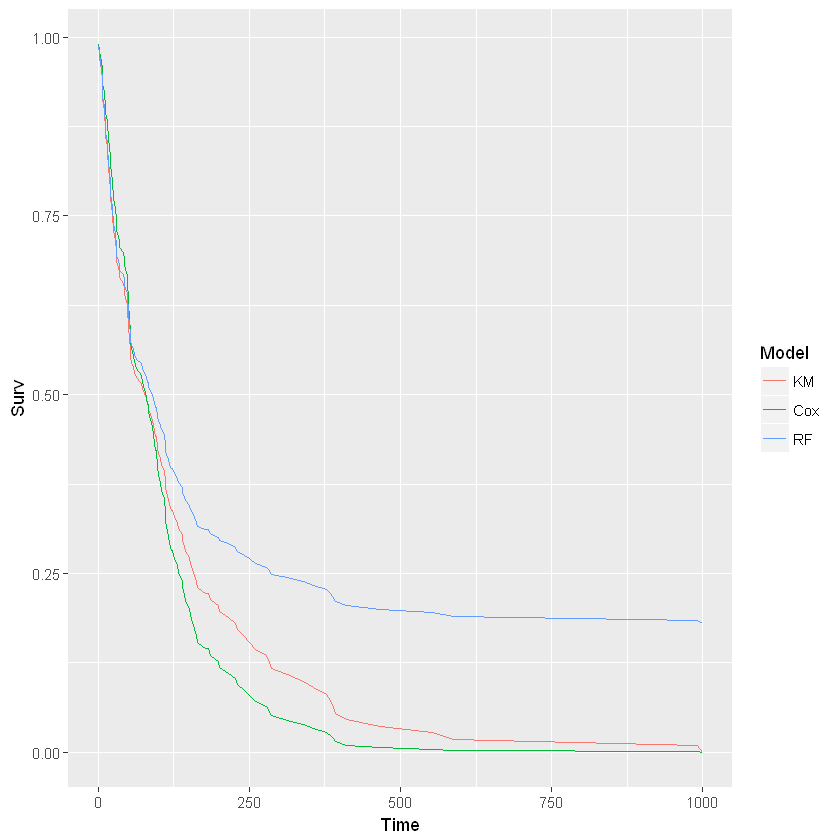

In [54]:
plot_df <- rbind(km_df, cox_df, rf_df)

p <- ggplot(plot_df, aes(x = Time, y = Surv, color = Model))
p + geom_line()

For this dataset, the best option might be a carefully constructed Cox model that takes into account the time varying components to Karno variable. There likely isn't enough data for the ranger() package to perform better, nor enough explanatory variables.<br>
